## **Monk Import**

In [1]:
import pandas as pd
from io import StringIO
import numpy as np

problem   = "monks-2"
dataset_path  = f"datasets/monks/{problem}"

train       = ".train"
test        = ".test"

f = open(dataset_path + train, 'r')
res = f.readlines()
f.close()
train_str = ''.join(res)

f = open(dataset_path + test, 'r')
res = f.readlines()
f.close()
test_str = ''.join(res)

def retrieveData(data_str):
    # Create a DataFrame from the structured data
    encoding_length = []
    column_names = ["R", "col2", "col3", "col4", "col5", "col6", "col7", "data"]
    column_features = ["col2", "col3", "col4", "col5", "col6", "col7"]
    data = pd.read_csv(StringIO(data_str), sep=' ', header=None, names=column_names)
    data = data.iloc[:, :-1]
    for col in column_features:
        encoding_length.append(max(data[col].unique()))
    data=data.iloc[np.random.permutation(len(data))]
    
    #scaler = MinMaxScaler()
    #df_scaled = scaler.fit_transform(data.to_numpy())
    df_scaled = pd.DataFrame(data.to_numpy(), columns=data.columns.values)
    del df_scaled['R']
    #del df_scaled['Id']
    df_scaled = df_scaled.assign(R=data['R'].values)
    df_train = df_scaled
    
    features = 6
    X_train = df_train.iloc[ : , :features].values
    y_train = df_train.iloc[:,features:].values
    return X_train, y_train, encoding_length

def oneHotEncoding(X_data, l):
    X_result = []
    for x in X_data:
        p = []
        for i in range(len(x)):
            d = [0] * l[i]
            if x[i] == 1:
                d[0] = 1
            elif x[i] == 2:
                d[1] = 1
            elif x[i] == 3:
                d[2] = 1
            elif x[i] == 4:
                d[3] = 1
            p += d
        X_result.append(p)
    return X_result

X_train, y_train, encoding_length = retrieveData(train_str)
X_train = oneHotEncoding(X_train, encoding_length)

X_test, y_test, encoding_length = retrieveData(test_str)
X_test = oneHotEncoding(X_test, encoding_length)

print("input len: ", len(X_train[0]))
print("output len: ", len(y_train[0]))

input len:  17
output len:  1


## **Model Selection - Hold-out Validation**

In [2]:
from activation_function import instantiate_act_func
from layer import Layer
from mlp import MLP
from losses import instantiate_loss
from grid_search import create_test
from weigth_init import instantiate_initializer
from utils import k_fold_cross_validation, hold_out_validation
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import trange

In [3]:
model_path  = f"models/monks-2"

json_file_config = [
    f"{model_path}/model1.json",
]
tests = create_test(json_file_config)

In [4]:
def create_model_from_test(test):
    layers = []
    for layer in test['layers']:
        layers.append(
            Layer(
                layer['units'],
                instantiate_act_func(layer['act_func']),
                layer['inputs'],
                weights_initializer=instantiate_initializer(test['weights_initializer']),
                kernel_regularizer=test['kernel_regularizer'],
                bias_regularizer=test['bias_regularizer'],
                momentum=test['momentum'],
                Nesterov=test['Nesterov']
            )
        )
    mlp = MLP(layers)
    mlp.compile(test['learning_rate'],instantiate_loss(test['loss']), test['metrics'])
    return mlp

In [5]:
def save_result(path, test, accuracy, summary):
    iso_date = datetime.now().replace(microsecond=0).isoformat()
    filename = f"{path}/{iso_date}-acc:{str(round(accuracy, 2))}"
    f = open(f"{filename}.logs", 'w')
    f.write(f"{str(test)}\n")
    f.write(f"{summary}\n")
    f.close()

In [6]:
def plot_chart(path, tr_res, vl_res, tr_label, vl_label, y_label):
    iso_date = datetime.now().replace(microsecond=0).isoformat()
    plt.plot(tr_res, label=tr_label, color='blue')
    plt.plot(vl_res, label=vl_label, color='red', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    filename = f"{path}/{iso_date}-{y_label}"
    plt.savefig(f'{filename}.png')
    plt.show()

In [7]:
path_model_selection_result = f"results/model-selection/{problem}"

{'learning_rate': 0.3, 'momentum': 0.9, 'Nesterov': True, 'kernel_regularizer': 0, 'bias_regularizer': 0, 'weights_initializer': 'random_init', 'layers': [{'units': 4, 'inputs': 17, 'act_func': 'sigmoid'}, {'units': 1, 'inputs': 4, 'act_func': 'sigmoid'}], 'name': 'model1', 'epochs': 400, 'loss': 'mean_squared_error', 'metrics': ['accuracy']}


(loss=0.004349): 100%|██████████| 400/400 [00:08<00:00, 44.75it/s]


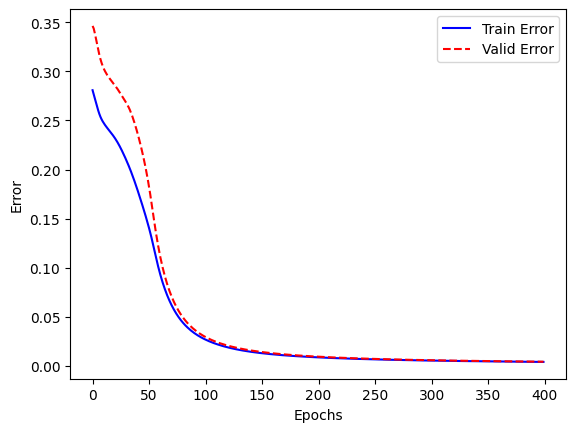

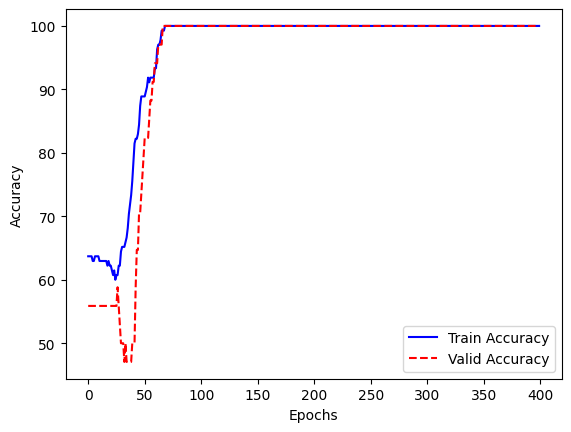

{'learning_rate': 0.09, 'momentum': 0.9, 'Nesterov': True, 'kernel_regularizer': 0, 'bias_regularizer': 0, 'weights_initializer': 'random_init', 'layers': [{'units': 4, 'inputs': 17, 'act_func': 'sigmoid'}, {'units': 1, 'inputs': 4, 'act_func': 'sigmoid'}], 'name': 'model1', 'epochs': 400, 'loss': 'mean_squared_error', 'metrics': ['accuracy']}


(loss=0.286847): 100%|██████████| 400/400 [00:09<00:00, 44.28it/s]


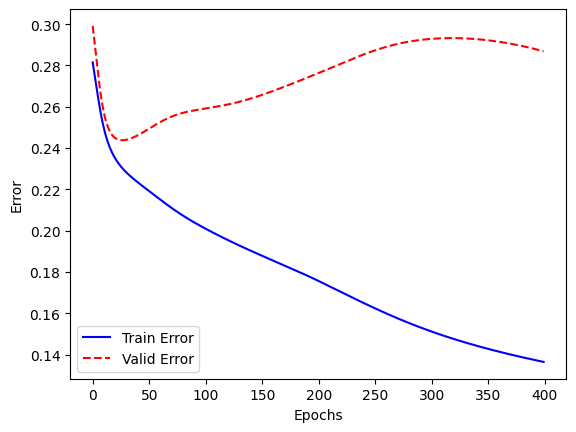

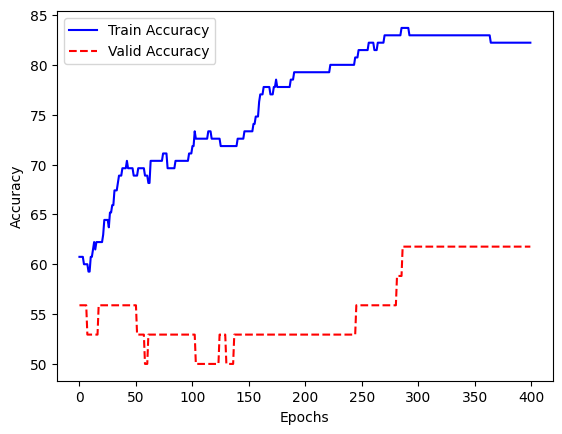

{'learning_rate': 0.1, 'momentum': 0.9, 'Nesterov': True, 'kernel_regularizer': 0, 'bias_regularizer': 0, 'weights_initializer': 'random_init', 'layers': [{'units': 4, 'inputs': 17, 'act_func': 'sigmoid'}, {'units': 1, 'inputs': 4, 'act_func': 'sigmoid'}], 'name': 'model1', 'epochs': 400, 'loss': 'mean_squared_error', 'metrics': ['accuracy']}


(loss=0.211604): 100%|██████████| 400/400 [00:09<00:00, 43.38it/s]


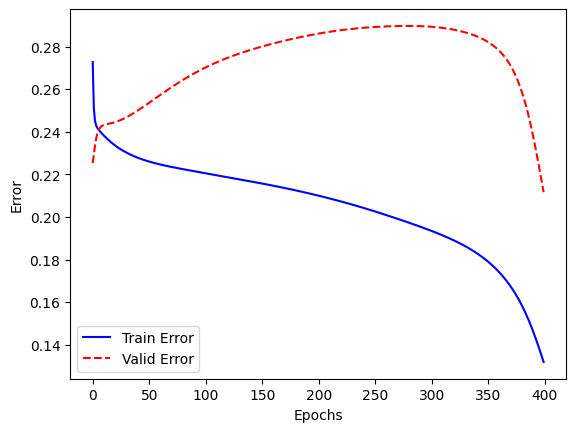

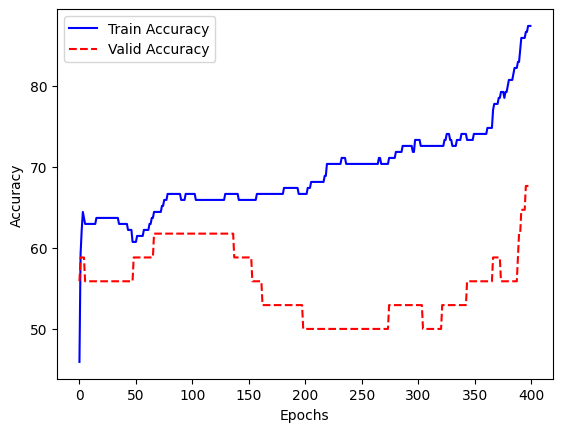

{'learning_rate': 0.2, 'momentum': 0.9, 'Nesterov': True, 'kernel_regularizer': 0, 'bias_regularizer': 0, 'weights_initializer': 'random_init', 'layers': [{'units': 4, 'inputs': 17, 'act_func': 'sigmoid'}, {'units': 1, 'inputs': 4, 'act_func': 'sigmoid'}], 'name': 'model1', 'epochs': 400, 'loss': 'mean_squared_error', 'metrics': ['accuracy']}


(loss=0.143934): 100%|██████████| 400/400 [00:09<00:00, 44.27it/s]


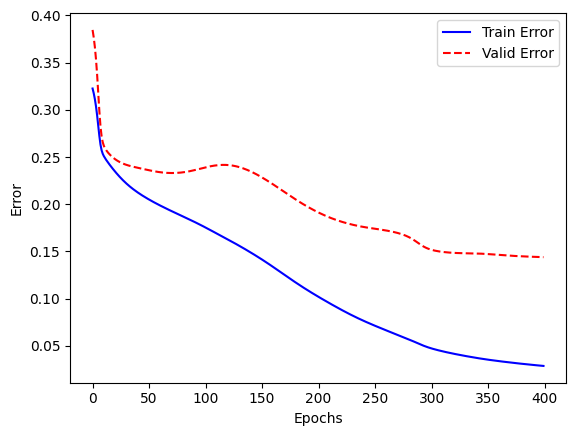

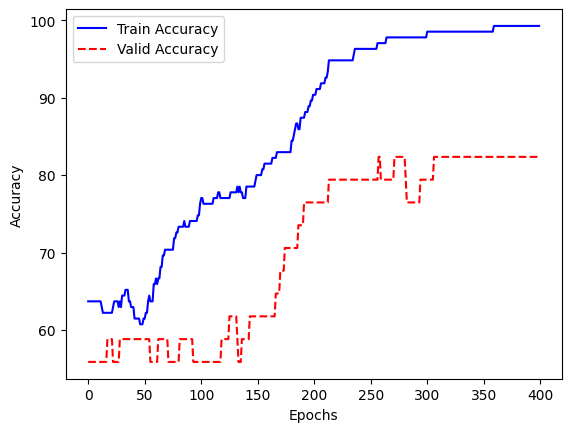

In [8]:
k = 1
best_model = None
best_accuracy = 0
for test in tests:
    epochs = round(test['epochs'] / k)
    model = create_model_from_test(test)
    dataset = hold_out_validation(X_train, y_train)
    print(test)
    tr_errors = []
    vl_errors = []
    tr_accuracies = []
    vl_accuracies = []
    for fold in dataset:
        bar = trange(epochs)
        for _ in bar:
            tr_error, tr_accuracy = model.fit(fold['X_train'], fold['y_train'], 1)
            vl_error, vl_accuracy = model.evaluate(fold['X_val'], fold['y_val'])
            tr_errors.append(tr_error[0])
            vl_errors.append(vl_error)
            tr_accuracies.append(tr_accuracy[0])
            vl_accuracies.append(vl_accuracy)
            bar.set_description(f'(loss={vl_error})')
        summary = model.summary()

    if best_accuracy < vl_accuracy:
        best_accuracy = vl_accuracy
        best_model = test

    save_result(path_model_selection_result, test, vl_accuracy, summary)
    plot_chart(path_model_selection_result, tr_errors, vl_errors, "Train Error", "Valid Error", "Error")
    plot_chart(path_model_selection_result, tr_accuracies, vl_accuracies, "Train Accuracy", "Valid Accuracy", "Accuracy")


## **Model  Assessment - Hold-out Validation**

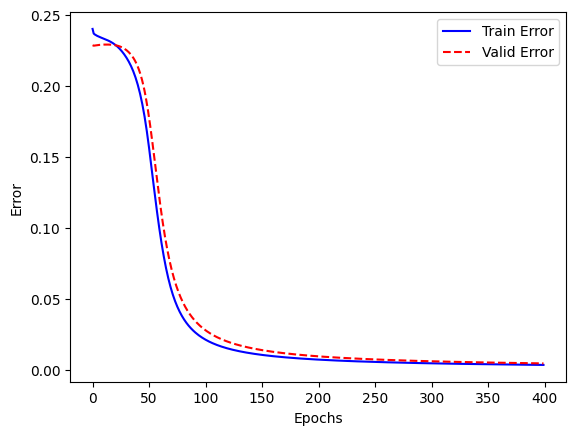

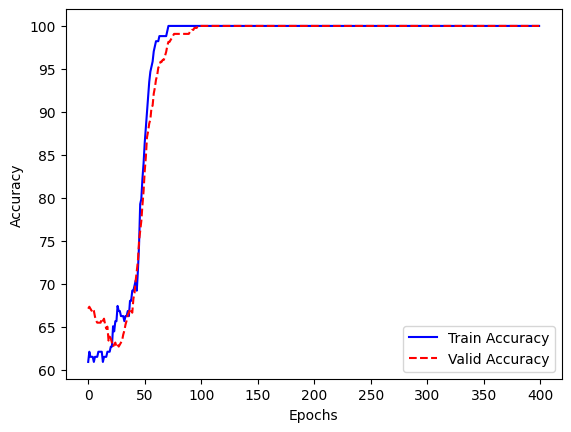

In [9]:
path_model_assessment_result = f"results/model-assessment/{problem}"
model = create_model_from_test(best_model)
tr_errors = []
vl_errors = []
tr_accuracies = []
vl_accuracies = []
for i in range(best_model['epochs']):
    tr_error, tr_accuracy = model.fit(X_train, y_train, 1)
    vl_error, vl_accuracy = model.evaluate(X_test, y_test)
    tr_errors.append(tr_error)
    vl_errors.append(vl_error)
    tr_accuracies.append(tr_accuracy[0])
    vl_accuracies.append(vl_accuracy)
summary = model.summary()

save_result(path_model_assessment_result, best_model, vl_accuracy, summary)
plot_chart(path_model_assessment_result, tr_errors, vl_errors, "Train Error", "Valid Error", "Error")
plot_chart(path_model_assessment_result, tr_accuracies, vl_accuracies, "Train Accuracy", "Valid Accuracy", "Accuracy")

In [10]:
model.save(path_model_assessment_result)